In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/stage/eyegauge")

In [3]:
import csv
import math
import pandas as pd
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import pickle
import random
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, MaxPooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from google.colab.patches import cv2_imshow
from tqdm import tqdm

import copy
image_size=224

# Image preprocessing

In [ ]:
data=pd.read_csv('./TlkWaterMeters/data.tsv', sep='\t')
data.photo_name[0]

'id_53_value_595_825.jpg'

In [ ]:
WMdata={}
WMsize={}
WMbox={}


In [ ]:
for id in data.index:
  path=data.photo_name[id]
  image=cv.imread("./TlkWaterMeters/images/"+path)
  WMsize[id]=image.shape[0:2]#h and w
  image=cv.resize(image,(image_size,image_size))#resize
  result = np.zeros(image.shape, dtype=np.float32)
  cv.normalize(image, result, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)#normalisation
  WMdata[id]=result

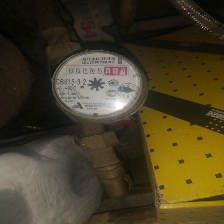

In [ ]:
cv2_imshow(np.uint8(WMdata[0]*255.0))#Reduction

In [ ]:
WMdata=np.array(list(WMdata.values()))
WMsize=np.array(list(WMsize.values()))
f=open("./new try/WMdata","wb+")
pickle.dump(WMdata,f,protocol=4)#store image array
f=open("./new try/WMsize","wb+")
pickle.dump(WMsize,f,protocol=4)#store original size

In [ ]:
for id in data.index:
  json = eval(data.location[id])
  points=np.zeros([8,2])#Set up eight pairs of coordinates, use the last one to fill the empty
  for i in range(8):
    for j in range(2):
      if j%2==0 and i<len(json.get('data')):  
        points[i][j]=json.get('data')[i].get('x')
      elif j%2!=0 and i<len(json.get('data')):
        points[i][j]=json.get('data')[i].get('y')
      elif j%2==0 and i>=len(json.get('data')):
        points[i][j]=points[i-1][j]
      else:
        points[i][j]=points[i-1][j]
  box=np.zeros(4)#Select the minimum value of x and y as x, y, and the difference between the maximum value and the minimum value as the height and width
  box[0]=(points.min(axis=0)[0])*image_size#Convert according to the picture ratio
  box[1]=(points.min(axis=0)[1])*image_size
  box[2]=(points.max(axis=0)[0])*image_size-box[0]
  box[3]=(points.max(axis=0)[1])*image_size-box[1]
  WMbox[int(id)]=box

In [ ]:
WMbox=np.array(list(WMbox.values()))

In [ ]:
f=open("./new try/WMbox","wb+") 
pickle.dump(WMbox,f,protocol=4)#store all the coordinates

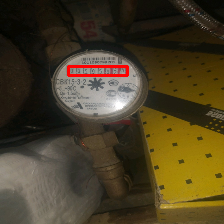

In [ ]:
true_box=WMbox[0]
image=np.uint8(WMdata[0]*255.0)
xmin=int(true_box[0])
ymin=int(true_box[1])
xmax=int(true_box[0]+true_box[2])
ymax=int(true_box[1]+true_box[3])
cv.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)  
cv2_imshow(image)

## Data augmentation

In [4]:
def random_translate(image, bbox, p=0.5):
  
    img=image.copy()
    bboxes=bbox.copy()
    if random.random() < p:
        h_img, w_img, _ = img.shape
       
        max_l_trans = bboxes[0]
        max_u_trans = bboxes[1]
        max_r_trans = w_img - bboxes[0]-bboxes[2]
        max_d_trans = h_img - bboxes[1]-bboxes[3]
 
        tx = random.uniform(-(max_l_trans - 1), (max_r_trans - 1))
        ty = random.uniform(-(max_u_trans - 1), (max_d_trans - 1))
 
        M = np.array([[1, 0, tx], [0, 1, ty]])
        img = cv.warpAffine(img, M, (w_img, h_img))
 
        bboxes[0] = bboxes[0] + tx
        bboxes[1] = bboxes[1] + ty
        
    return img, bboxes

In [5]:
def random_horizontal_flip(image, bbox, p=0.5):
    img=image.copy()
    bboxes=bbox.copy()
    if random.random() < p:
        _, w_img, _ = img.shape
        img = img[:, ::-1, :]
        bboxes[0] = w_img - bboxes[0]-bboxes[2]
    return img, bboxes

In [6]:
def random_vertical_flip(image, bbox, p=0.5):
    img=image.copy()
    bboxes=bbox.copy()
    if random.random() < p:
        h_img, _, _ = img.shape
        img = img[::-1, :, :]
        bboxes[1] = h_img - bboxes[1]- bboxes[3]
    return img, bboxes


In [7]:
def random_rot(img, bbox, angle,scale=1.0,):
    image=img.copy()
    bboxes=bbox.copy()
    (h, w) = image.shape[:2]
    #set center
    center = (w / 2, h / 2)
    # rotate
    M = cv.getRotationMatrix2D(center, angle, scale)
    
    box_x, box_y,box_tmp = [], [], []

    box_x.append(int(bboxes[0]))
    box_x.append(int(bboxes[0]+bboxes[2]))
    box_y.append(int(bboxes[1]))
    box_y.append(int(bboxes[1]+bboxes[3]))
    box_tmp.append(box_x)
    box_tmp.append(box_y)
    bboxe = np.array(box_tmp)
    ####make it as a 3x3 RT matrix
    full_M = np.row_stack((M, np.asarray([0,0,1])))
    img_rotated = cv.warpAffine(image, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_CONSTANT)

    ###make the bboxes as 3xN matrix
    full_bboxes = np.row_stack((bboxe, np.ones(shape=(1, bboxe.shape[1]))))
    bboxes_rotated = np.dot(full_M, full_bboxes)

    bboxes_rotated = bboxes_rotated[0:2, :]
    bboxes_rotated = bboxes_rotated.astype(np.int32)

    x1, y1, x2, y2 = bboxes_rotated[0][0], bboxes_rotated[1][0], bboxes_rotated[0][1], bboxes_rotated[1][1]
    x1, y1, x2, y2 = max(0, x1), max(0, y1), max(0, x2), max(0, y2)
    x1, x2 = min(w, x1), min(w, x2)
    y1, y2 = min(h, y1), min(h, y2)
    bboxes[0]=x1
    bboxes[1]=y1
    bboxes[2]=x2-x1 
    bboxes[3]=y2-y1  
    return img_rotated, bboxes


In [8]:
def random_bright(image, bbox, p=0.5, lower=0.5, upper=1.5):
    img=image.copy()
    bboxes=bbox.copy()
    if random.random() < p:
        mean = np.mean(img)
        img = img - mean
        img = img * random.uniform(lower, upper) + mean * random.uniform(lower, upper)  # 亮度
        #img = img / 255.
    return img, bboxes


In [9]:
def random_saturation(image, bbox, p=0.5, lower=0.5, upper=1.5):
    img=image.copy()
    bboxes=bbox.copy()
    if random.random() < p:
        img[:, :, 1] = img[:, :, 1] * random.uniform(lower, upper)
    return img, bboxes


In [10]:
from random import choice
plt.switch_backend('agg')

def dataGenerator(per,p,time):
  '''
  Divide the data into training set and test set and data augmentation
  per: Proportion of training set
  p: proportion off doing each operation
  '''
  f=open("./new try/WMdata","rb+")
  data=pickle.load(f)
  index=[i for i in range(len(data))]
  data=data[index]
  per=int(per*len(data))
  data_train=data[0:per]
  data_test=data[per:]
  
  f=open("./new try/WMbox","rb+")
  box=pickle.load(f)
  box=box[index]
  box_train=box[0:per]
  box_test=box[per:]
  l=len(data_train)
  for t in range(time):
    for idx in tqdm(range(l)):
        x=random.randint(1,6)
        ag=[-90,90,180]
        if x==1:
          img,bbox=random_translate(data_train[idx], box_train[idx], p)
        elif x==2:
          img,bbox=random_horizontal_flip(data_train[idx], box_train[idx], p)
        elif x==3:
          img,bbox=random_vertical_flip(data_train[idx], box_train[idx], p)
        elif x==4:
          img,bbox=random_rot(data_train[idx], box_train[idx], angle=choice(ag),scale=1.0)
        elif x==5:
          img,bbox=random_bright(data_train[idx], box_train[idx], p, lower=0.8, upper=1.2)
        else:
          img,bbox=random_saturation(data_train[idx], box_train[idx], p, lower=0.5, upper=1.5)
        img=img[np.newaxis, :]
        bbox=bbox[np.newaxis, :]
        data_train=np.vstack([data_train, img])
        box_train=np.vstack([box_train, bbox])
    
  return data_train,box_train,data_test,box_test

In [11]:
data_train,box_train,data_test,box_test=dataGenerator(0.95,1,4)

100%|██████████| 1181/1181 [18:09<00:00,  1.08it/s]


In [25]:
box_train.shape

(5905, 4)

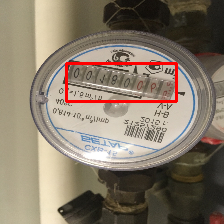

In [59]:
i=2345
true_box=box_train[i]
image=np.uint8(data_train[i]*255.0)
xmin=int(true_box[0])
ymin=int(true_box[1])
xmax=int(true_box[0]+true_box[2])
ymax=int(true_box[1]+true_box[3])
cv.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)  
cv2_imshow(image)

In [12]:
def plot_model(model_details):
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    axs[0].plot(range(1,len(model_details.history['cus_metric'])+1),model_details.history['cus_metric'])
    axs[0].plot(range(1,len(model_details.history['val_cus_metric'])+1),[1.7*x for x in model_details.history['val_cus_metric']])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['cus_metric'])+1),len(model_details.history['cus_metric'])/10)
    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    plt.savefig("./new try/model_5_4.png")

# Train

In [13]:
def cus_metric(labels,predictions):
  '''
  Reflects the overlap between the predicted detection box and the real detection box
  ''' 
  threshhold=0.75

  x=predictions[:,0]*image_size
  x=tf.maximum(tf.minimum(x,image_size),0.0)
  y=predictions[:,1]*image_size
  y=tf.maximum(tf.minimum(y,image_size),0.0)
  width=predictions[:,2]*image_size
  width=tf.maximum(tf.minimum(width,image_size),0.0)
  height=predictions[:,3]*image_size
  height=tf.maximum(tf.minimum(height,image_size),0.0)
  label_x=labels[:,0]
  label_y=labels[:,1]
  label_width=labels[:,2]
  label_height=labels[:,3]

  a1=tf.multiply(width,height)
  a2=tf.multiply(label_width,label_height)
  x1=tf.maximum(x,label_x)
  y1=tf.maximum(y,label_y)
  x2=tf.minimum(x+width,label_x+label_width)
  y2=tf.minimum(y+height,label_y+label_height)
  IoU=tf.abs(tf.multiply((x1-x2),(y1-y2)))/(a1+a2-tf.abs(tf.multiply((x1-x2),(y1-y2))))
  condition=tf.less(threshhold,IoU)
  sum=tf.where(condition,tf.ones(tf.shape(condition)),tf.zeros(tf.shape(condition)))
  return tf.reduce_mean(sum)

In [14]:
def smooth_l1_loss(true_box,pred_box):
    loss=0.0
    for i in range(4):
        residual=tf.abs(true_box[:,i]-pred_box[:,i]*image_size)
        condition=tf.less(residual,1.0)
        small_res=0.5*tf.square(residual)
        large_res=residual-0.5
        loss=loss+tf.where(condition,small_res,large_res)
    return tf.reduce_mean(loss)

In [15]:
def resnet_block(inputs,num_filters,kernel_size,strides,activation='relu'):
    x=Conv2D(num_filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(inputs)
    x=BatchNormalization()(x)
    if(activation):
        x=Activation('relu')(x)
    return x

In [16]:
def resnet18():
    inputs=Input((image_size,image_size,3))
    
    # conv1
    x=resnet_block(inputs,64,[7,7],2)

    # conv2
    x=MaxPooling2D([3,3],2,'same')(x)
    for i in range(2):
        a=resnet_block(x,64,[3,3],1)
        b=resnet_block(a,64,[3,3],1,activation=None)
        x=keras.layers.add([x,b])
        x=Activation('relu')(x)
    
    # conv3
    a=resnet_block(x,128,[1,1],2)
    b=resnet_block(a,128,[3,3],1,activation=None)
    x=Conv2D(128,kernel_size=[1,1],strides=2,padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(x)
    x=keras.layers.add([x,b])
    x=Activation('relu')(x)

    a=resnet_block(x,128,[3,3],1)
    b=resnet_block(a,128,[3,3],1,activation=None)
    x=keras.layers.add([x,b])
    x=Activation('relu')(x)

    # conv4
    a=resnet_block(x,256,[1,1],2)
    b=resnet_block(a,256,[3,3],1,activation=None)
    x=Conv2D(256,kernel_size=[1,1],strides=2,padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(x)
    x=keras.layers.add([x,b])
    x=Activation('relu')(x)

    a=resnet_block(x,256,[3,3],1)
    b=resnet_block(a,256,[3,3],1,activation=None)
    x=keras.layers.add([x,b])
    x=Activation('relu')(x)

    # conv5
    a=resnet_block(x,512,[1,1],2)
    b=resnet_block(a,512,[3,3],1,activation=None)
    x=Conv2D(512,kernel_size=[1,1],strides=2,padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(x)
    x=keras.layers.add([x,b])
    x=Activation('relu')(x)

    a=resnet_block(x,512,[3,3],1)
    b=resnet_block(a,512,[3,3],1,activation=None)
    x=keras.layers.add([x,b])
    x=Activation('relu')(x)

    x=AveragePooling2D(pool_size=7,data_format="channels_last")(x)

    y=Flatten()(x)

    y=Dense(1000,kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(y)
    outputs=Dense(4,kernel_initializer='he_normal',kernel_regularizer=l2(1e-3))(y)
    
    model=Model(inputs=inputs,outputs=outputs)
    return model

In [17]:
def lr_sch(epoch):
    if epoch <50:
        return 1e-3
    if 50<=epoch<100:
        return 1e-4
    if epoch>=100:
        return 1e-5

In [18]:
def lr_sch(epoch):
    if epoch <50:
        return 1e-3
    if 50<=epoch<100:
        return 1e-4
    if 100<=epoch<150:
        return 1e-5
    if epoch>=150:
        return 1e-6

In [19]:
model = resnet18()

In [20]:
model.compile(loss=smooth_l1_loss,optimizer=Adam(),metrics=[cus_metric])

In [21]:
lr_scheduler=LearningRateScheduler(lr_sch)
lr_reducer=ReduceLROnPlateau(monitor='val_cus_metric',factor=0.2,patience=5,mode='max',min_lr=1e-3)

checkpoint=ModelCheckpoint('./new try/model_5_4.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [64]:
model_details=model.fit(data_train,box_train,batch_size=64,epochs=200,shuffle=True,validation_split=0.1,callbacks=[lr_scheduler,lr_reducer,checkpoint],verbose=1)

model.save('./new try/model_2_4.h5')

Epoch 1/200
50/50 [==============================] - 16s 236ms/step - loss: 3027.2896 - cus_metric: 0.1196 - val_loss: 22391.0449 - val_cus_metric: 0.0152
Epoch 2/200
50/50 [==============================] - 10s 196ms/step - loss: 160.7751 - cus_metric: 0.1330 - val_loss: 154.0687 - val_cus_metric: 0.1848
Epoch 3/200
50/50 [==============================] - 10s 194ms/step - loss: 158.8230 - cus_metric: 0.1724 - val_loss: 172.2589 - val_cus_metric: 0.0772
Epoch 4/200
50/50 [==============================] - 10s 193ms/step - loss: 134.9263 - cus_metric: 0.1147 - val_loss: 127.9661 - val_cus_metric: 0.1184
Epoch 5/200
50/50 [==============================] - 9s 190ms/step - loss: 132.4637 - cus_metric: 0.1399 - val_loss: 231.8765 - val_cus_metric: 0.2022
Epoch 6/200
50/50 [==============================] - 10s 192ms/step - loss: 107.1354 - cus_metric: 0.0970 - val_loss: 306.4359 - val_cus_metric: 0.0846
Epoch 7/200
50/50 [==============================] - 10s 191ms/step - loss: 111.0056 -

In [67]:
scores=model.evaluate(data_test,box_test,verbose=1)
print('Test loss : ',scores[0])
print('Test accuracy : ',scores[1])

2/2 [==============================] - 0s 46ms/step - loss: 38.1100 - cus_metric: 0.0801
Test loss :  38.11001968383789
Test accuracy :  0.08014112710952759


In [22]:
model_details=model.fit(data_train,box_train,batch_size=128,epochs=200,shuffle=True,validation_split=0.1,callbacks=[lr_scheduler,lr_reducer,checkpoint],verbose=1)

model.save('./new try/model_5_4.h5')

Epoch 1/200
42/42 [==============================] - 54s 402ms/step - loss: 3427.7288 - cus_metric: 0.0811 - val_loss: 88273.3516 - val_cus_metric: 0.0486
Epoch 2/200
42/42 [==============================] - 15s 347ms/step - loss: 182.7645 - cus_metric: 0.1611 - val_loss: 734.9304 - val_cus_metric: 0.0962
Epoch 3/200
42/42 [==============================] - 15s 352ms/step - loss: 146.9225 - cus_metric: 0.1498 - val_loss: 207.5650 - val_cus_metric: 0.1472
Epoch 4/200
42/42 [==============================] - 15s 357ms/step - loss: 143.1850 - cus_metric: 0.1196 - val_loss: 177.7421 - val_cus_metric: 0.0523
Epoch 5/200
42/42 [==============================] - 15s 364ms/step - loss: 127.2031 - cus_metric: 0.1148 - val_loss: 137.9609 - val_cus_metric: 0.0990
Epoch 6/200
42/42 [==============================] - 15s 368ms/step - loss: 110.4498 - cus_metric: 0.0973 - val_loss: 122.5220 - val_cus_metric: 0.1351
Epoch 7/200
42/42 [==============================] - 16s 375ms/step - loss: 97.3284 -

In [24]:
scores=model.evaluate(data_test,box_test,verbose=1)
print('Test loss : ',scores[0])
print('Test accuracy : ',scores[1])

2/2 [==============================] - 1s 296ms/step - loss: 42.1238 - cus_metric: 0.1114
Test loss :  42.123775482177734
Test accuracy :  0.11139112710952759


In [23]:
plot_model(model_details)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


# Test

In [4]:
plt.switch_backend('agg')

f=open("./new try/WMdata","rb+")
data=pickle.load(f)

f=open("./new try/WMbox","rb+")
box=pickle.load(f)

f=open("./new try/WMsize","rb+") 
size=pickle.load(f)

In [5]:
size.shape

(1244, 2)

[1333 1000]


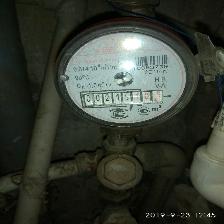

In [6]:
print(size[1119])
cv2_imshow(np.uint8(data[1119]*255.0))

In [7]:
p=0.95#proportion of training set
test_data=data[int(p*len(data)):]
test_size=size[int(p*len(data)):]
test_box=box[int(p*len(data)):]

In [8]:
index=[i for i in range(len(test_data))]
model=keras.models.load_model("./new try/model_2_4.h5",compile=False)
result=model.predict(test_data[index,:,:,:])

In [9]:
from tqdm import tqdm

for i in tqdm(index):
    print("Predicting "+str(i)+"th image.")
    true_box=test_box[i]
    image=np.uint8(test_data[i]*255.0)
    #true box
    prediction=result[i]
    xmin=int(true_box[0])
    ymin=int(true_box[1])
    xmax=int(true_box[0]+true_box[2])
    ymax=int(true_box[1]+true_box[3])
    cv.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    #predict box
    pxmin=int(prediction[0]*224)
    pymin=int(prediction[1]*224)
    pxmax=int((prediction[0]+prediction[2])*224)
    pymax=int((prediction[1]+prediction[3])*224)
    cv.rectangle(image, (pxmin, pymin), (pxmax, pymax), (0, 0, 255), 2)  

    cv2_imshow(image)
    image=cv.resize(image,(test_size[i][1],test_size[i][0]))

    cv.imwrite("./new try/prediction/"+str(i)+".png", image)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
index=[i for i in range(len(test_data))]
model=keras.models.load_model("./new try/model_5_4.h5",compile=False)
result=model.predict(test_data[index,:,:,:])

In [11]:
from tqdm import tqdm

for i in tqdm(index):
    print("Predicting "+str(i)+"th image.")
    true_box=test_box[i]
    image=np.uint8(test_data[i]*255.0)
    #true box
    prediction=result[i]
    xmin=int(true_box[0])
    ymin=int(true_box[1])
    xmax=int(true_box[0]+true_box[2])
    ymax=int(true_box[1]+true_box[3])
    cv.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    #predict box
    pxmin=int(prediction[0]*224)
    pymin=int(prediction[1]*224)
    pxmax=int((prediction[0]+prediction[2])*224)
    pymax=int((prediction[1]+prediction[3])*224)
    cv.rectangle(image, (pxmin, pymin), (pxmax, pymax), (0, 0, 255), 2)  

    cv2_imshow(image)
    image=cv.resize(image,(test_size[i][1],test_size[i][0]))

    cv.imwrite("./new try/prediction_5/"+str(i)+".png", image)

Output hidden; open in https://colab.research.google.com to view.

# Reference:

https://github.com/ckczzj/Image-Object-Localization



